In [1]:
import argparse, os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cucim
import data.utils_metrics as utils_met
import cucim.skimage.metrics as met

7T scan resolution : 173, 207, 173

3T scan resolution : 145, 174, 143

In [2]:
parser = argparse.ArgumentParser(description="IMDN")
parser.add_argument("--block_size", type=tuple, default=(64,64,1),
                    help="Block Size")
parser.add_argument("--test_size", type=tuple, default=(173,207,1),
                    help="test_size")
parser.add_argument("--crop_depth", type=int, default=30,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="dataset_directory")
parser.add_argument("--sort", type=bool,
                    help="dataset_directory")
parser.add_argument("--debug", type=bool,
                    help="dataset_directory")
parser.add_argument("--preload", type=bool,
                    help="dataset_directory")
args = list(parser.parse_known_args())[0]
args.preload = True
args.debug = False
args.dir = "/storage"
args.batch_size = 4
args.sort = True
args.typ = 'upsampled'
print(args)

Namespace(batch_size=4, block_size=(64, 64, 1), crop_depth=30, debug=False, dir='/storage', preload=True, sort=True, test_size=(173, 207, 1), typ='upsampled')


In [3]:
import utils
import data.HCP_dataset_h5 as HCP_dataset

ids = utils.get_ids()
ids.sort()
ids = ids[:5]
dataset_hcp = HCP_dataset
dataset_hcp.load_data(args.dir,ids)
training_dataset = dataset_hcp.hcp_data(args,ids)
testing_dataset = dataset_hcp.hcp_data_test(args,ids)

number of common Subjects  171


In [4]:
len(testing_dataset)

5

In [5]:
len(training_dataset)

2413

In [6]:
x = testing_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape)

(145, 174, 145, 8) (173, 207, 173) (173, 207, 173) (173, 207, 173, 3)


In [7]:
x = training_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape)

(64, 64, 1, 8) (64, 64, 1) (64, 64, 1) (64, 64, 1, 3)


In [8]:
training_dataset.blk_indx

array([ 489,  965, 1437, 1942, 2413])

In [9]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=4, shuffle=True, pin_memory=True, drop_last=True)#,collate_fn=resize)
testing_data_loader = DataLoader(dataset=testing_dataset, batch_size=1,pin_memory=True)#,collate_fn=resize)

In [10]:
print(len(training_data_loader))

603


In [11]:
len(training_dataset)

2413

In [12]:
temp = next(iter(testing_data_loader))

In [13]:
temp[0].shape

torch.Size([1, 145, 174, 145, 8])

In [14]:
temp[1].shape

torch.Size([1, 173, 207, 173])

In [15]:
def resize(data):
    x,y = [],[]
    for i in range(len(data)):
        x.append(data[i][0].reshape((data[i][0].shape[0]*data[i][0].shape[1],data[i][0].shape[2],data[i][0].shape[3])))
        y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
    return torch.from_numpy(np.stack(x)),torch.from_numpy(np.stack(y))

training_data_loader = DataLoader(dataset=training_dataset, batch_size=40, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)

In [16]:
for iteration, (lr_tensor, hr_tensor) in enumerate(training_data_loader, 1):
    print(lr_tensor.shape,hr_tensor.shape)
    break

torch.Size([40, 4096, 1, 8]) torch.Size([40, 64, 64, 1, 5])


In [17]:
temp = next(iter(training_data_loader))
temp[0] = torch.permute(temp[0],(0,3,1,2))
temp[0].shape

torch.Size([40, 8, 4096, 1])

In [18]:
temp[1].shape

torch.Size([40, 64, 64, 1, 5])

## DUAL ARBNET

In [28]:
from Dual_ArbNet import model as arbmodel
from Dual_ArbNet.option import args

In [29]:
model = arbmodel.Model(args)

Making model...


In [30]:
model

Model(
  (model): DataParallel(
    (module): DUALRef(
      (encoder): RDN(
        (SFENet1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (SFENet2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (RDBs): ModuleList(
          (0-4): 5 x RDB(
            (convs): Sequential(
              (0): RDB_Conv(
                (conv): Sequential(
                  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                  (1): ReLU()
                )
              )
              (1): RDB_Conv(
                (conv): Sequential(
                  (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                  (1): ReLU()
                )
              )
              (2): RDB_Conv(
                (conv): Sequential(
                  (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                  (1): ReLU()
                )
              )
           

In [22]:
model.get_model().set_scale(1.1,1.3)

In [16]:
x = training_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape)

(64, 64, 1, 8) (64, 64, 1) (64, 64, 1) (64, 64, 1, 3)


In [24]:
x[0].shape,len(x)

((64, 64, 1, 8), 4)

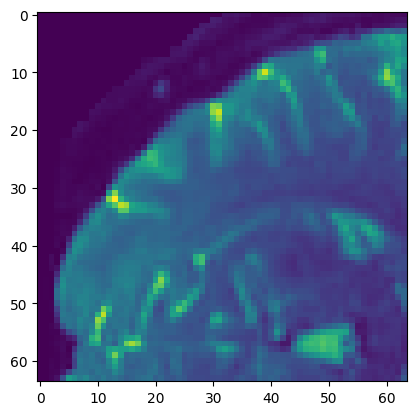

In [25]:
plt.imshow(training_dataset[50][0][:,:,0,0])

In [26]:
training_dataset[50][0][:,:,0,0].shape

(64, 64)

In [27]:
temp = model(training_dataset[50][0][:,:,0,0])

ValueError: Caught ValueError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1533, in _call_impl
    return forward_call(*args, **kwargs)
  File "/workspace/DMRI_SR/Dual_ArbNet/model/dualref.py", line 139, in forward
    if ref_type == None:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


In [32]:
isinstance(training_dataset[50][0][:,:,0,0],list)

False